# Import

In [ ]:
import os, sys

import keras

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multyadding  
    sys.path.append("../scripts/") 
from timeit import timeit 
# types
import collections
import pickle
import itertools
import datetime
import re
import io
import cv2
import time
# work with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample, class_weight
import sklearn.metrics

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, DepthwiseConv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Dropout, RandomFlip, RandomRotation
from tensorflow.keras import Model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

# my scripts
from plotting import plot_confusion_matrix, plot_to_image

In [3]:
%load_ext tensorboard

# Consts

In [4]:
data_dir = "../data"
res_dir = "../results"
img_size = 48
emotions=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']    
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
checkpoint_dir = "checkpoints/"

BATCH_SIZE = 64
init_learning_rate = 0.001

# !Functions 

In [6]:
def test():
    x = np.arange(-0.5, 6, 1) 
    y = np.arange(4.5, 11, 1) 
    cm = np.array((x,y)*3)
    cm = np.concatenate((cm, y[np.newaxis,:]), axis=0)
    f=plot_confusion_matrix(cm,emotions)


# Load train and test sets

## Read data

In [7]:
def str2pixels(s, image_w=img_size):
    return np.array(s.split(' '), dtype=np.uint8).reshape(-1, image_w)   

In [8]:
def normalize_images(imgs):
    return imgs/255.

In [9]:
def read_data(path):
    df = pd.read_csv(path,dtype={'emotion':np.int8},  converters={'pixels': str2pixels}, usecols=['emotion', 'pixels'])
    Xx = np.empty((len(df), img_size, img_size), dtype=np.uint8)
    i = 0
    for arr in df['pixels']:
        Xx[i,:,:] = arr
        i+=1
    return np.expand_dims(normalize_images(Xx), axis=-1), df['emotion'].to_numpy()  #normilize Xx and add to it a dimension for channels 

In [10]:
X_train, y_train_orig = read_data(os.path.join(data_dir, "train.csv"))
X_test, y_test_orig = read_data(os.path.join(data_dir, "test_with_emotions.csv"))

## Balance the distribution of input data

In [11]:
X_disgust_upsampled, y_disgust_upsampled = resample(X_train[y_train_orig == 1],
                                    y_train_orig[y_train_orig == 1],
                                    replace=True,
                                    n_samples=2000,
                                    random_state=25)
X_surprise_upsampled, y_surprise_upsampled = resample(X_train[y_train_orig == 5],
                                    y_train_orig[y_train_orig == 5],
                                    replace=True,
                                    n_samples=900,
                                    random_state=25)

# unite upsampled sets to the origin sets
X_train_balanced = np.vstack((X_train, X_disgust_upsampled, X_surprise_upsampled))
y_train_balanced = np.hstack((y_train_orig, y_disgust_upsampled, y_surprise_upsampled))


## Convert Y to one-to-hot

In [12]:
# Convert training and test labels to one-to-hot 
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train_orig)
y_test = lb.transform(y_test_orig)

print('***X_train***')
print (f"number of training examples = {str(X_train.shape[0])} (shape={X_train.shape})")
print(f"type of items: {X_train.dtype}\ntakes {round(X_train.nbytes/1024/1024, 2)}Mb")
print('***X_test***')
print (f"number of test examples = {str(X_test.shape[0])} (shape={X_test.shape})")
print(f"shape={X_test.shape}\ntype of items: {X_test.dtype}\ntakes {round(X_test.nbytes/1024/1024, 2)}Mb")
print('**********')
print("Y classes: ", lb.classes_)

***X_train***
number of training examples = 28709 (shape=(28709, 48, 48, 1))
type of items: float64
takes 504.65Mb
***X_test***
number of test examples = 7178 (shape=(7178, 48, 48, 1))
shape=(7178, 48, 48, 1)
type of items: float64
takes 126.18Mb
**********
Y classes:  [0 1 2 3 4 5 6]


In [13]:
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_test = tf.data.Dataset.from_tensor_slices((X_test, y_test))

## Output some pictures

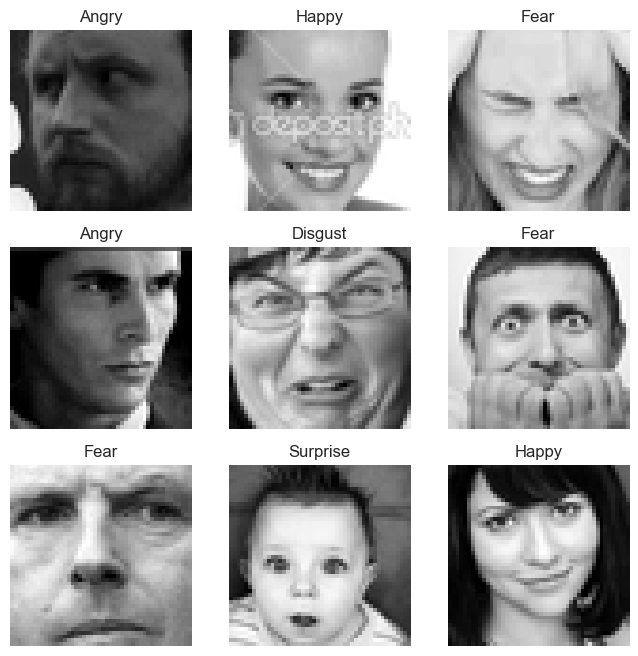

In [14]:
offset=295
plt.figure(figsize=(8, 8))
i=0
for image, label in ds_train.skip(offset).take(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy(), cmap='gray')
    plt.title(emotions[label.numpy().argmax()])
    plt.axis("off")
    i+=1

In [15]:
ds_train = ds_train.shuffle(ds_train.cardinality(), reshuffle_each_iteration=True).batch(BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.prefetch(buffer_size=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE)

# Create CNN

## Data augmentation

In [16]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers: RandomFlip and RandomRotation
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip(mode = 'horizontal', name='Flip'))
    data_augmentation.add(RandomRotation(factor=0.1,name='Rotation'))
    
    return data_augmentation

## Functions to create blocks of a residual network.

### 3-layers blocks

In [17]:
def identity_block(X, f, filters, initializer=random_uniform, normalization=True, kernel_regularizer=None):
    """
    Implementation of a#the convolutional block of the residual network with identity output size to input size.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights in Conv layers
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
        
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

In [18]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform, normalization=True, kernel_regularizer=None):
    """
    Implementation of the convolutional block of the residual network with output size different to input size.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights in Conv layers
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = F2, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path
    # TODO try kernel_size = f, strides = (1, 1), padding='same'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X_shortcut)
    if normalization:
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

### 2-layers blocks

In [19]:
def identity_block2(X, f, initializer=random_uniform, normalization=True, kernel_regularizer=None):
    """
    Implementation of a#the convolutional block of the residual network with identity output size to input size.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the CONV's window for the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights in Conv layers
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    filters = X.shape[-1]
    # First component of main path
    X = Conv2D(filters = filters, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    
    ## Second component of main path
    X = Conv2D(filters = filters, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
        
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X) 

    return X

In [20]:
def pooling_block(X, f, filters, s = 2, initializer=glorot_uniform, normalization=True, kernel_regularizer=None):
    """
    Implementation of the convolutional block of the residual network with output size different to input size.
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- integer, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used in the MaxPooling
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights in Conv layers
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
       
    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform(seed=0)
    X = MaxPooling2D((s, s), strides=(s, s))(X)
    
    ## Second component of main path
    X = Conv2D(filters = filters, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    ## Third component of main path
    X = Conv2D(filters = filters, kernel_size = f, strides = (1, 1), padding='same', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X) # Default axis
    
    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = filters, kernel_size = (s, s), strides=(s, s), padding='valid', kernel_initializer = initializer(seed=0),kernel_regularizer=kernel_regularizer)(X_shortcut)
    if normalization:
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    
    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X
    

## Functions to create residual CNN models

In [23]:
def ResNetLarge(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=None, normalization=True, kernel_regularizer=None):
    """
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    data_augmentation -- data augmentation model
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights
    
    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    if data_augmentation is not None:
        X = data_augmentation(X_input)
    else:
        X = X_input
    # Stage 1
    X = Conv2D(64, (4, 4), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 128, 128], s = 1, normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [128, 128, 128], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [128, 128, 128], normalization=normalization, kernel_regularizer=kernel_regularizer)

    ## Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 256, 256], s = 2, normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    X = identity_block(X, 3, [256, 256, 256], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [256, 256, 256], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [256, 256, 256], normalization=normalization, kernel_regularizer=kernel_regularizer)

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 512, 512], s = 2, normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    X = identity_block(X, 3, [512, 512, 512], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [512, 512, 512], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [512, 512, 512], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [512, 512, 512], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [512, 512, 512], normalization=normalization, kernel_regularizer=kernel_regularizer)

    # Stage 5 
    X = convolutional_block(X, f = 3, filters = [512, 1024, 1024], s = 2, normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    X = identity_block(X, 3, [1024, 1024, 1024], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [1024, 1024, 1024], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [1024, 1024, 1024], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [1024, 1024, 1024], normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    X = convolutional_block(X, f = 3, filters = [1024, 2048, 2048], s = 1, normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    X = identity_block(X, 3, [2048, 2048, 2048], normalization=normalization, kernel_regularizer=kernel_regularizer)
    X = identity_block(X, 3, [2048, 2048, 2048], normalization=normalization, kernel_regularizer=kernel_regularizer)
    # AVGPOOL
    X = AveragePooling2D((2,2))(X) #default stride=pool_size
    
    # output layer
    X = Flatten()(X)
    X = Dense(X.shape[1], activation='relu', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    X = Dense(X.shape[1], activation='relu', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
        
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [24]:
def create_ResNet3(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=None, stages={}, normalization=True, kernel_regularizer=None, addition_FCs=0, name='resNet3'):
    """
    creates a model of residual network using triple convolutional and identity blocks 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    data_augmentation -- data augmentation model
    stages -- dict of kind {"identity_blocks":<list of integer>, "f":<list of integer>, "filters":<list of lists of integers>, "s":<list of integer>}, where
        identity_blocks -- defines the number of identity_block for each stage
        f -- specifies the shape of the window to be used in convolutional and identical blocks
        filters -- defines the number of filters to be used in the blocks. Three filters for each block. If it is not supposed to use identity blocks for stage 0, the list must contain at least 1 item for conv layer
        s -- specifies the stride to be used in the convolutional block
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights
    addition_FCs -- defines the number of fully connected layer added before the softmax layer 
    name -- defines the name of the model
    
    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    if data_augmentation is not None:
        X = data_augmentation(X_input)
    else:
        X = X_input

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X)
    
    # Stage 0
    X = Conv2D(stages['filters'][0][0], kernel_size = stages['f'][0], strides = (stages['s'][0],stages['s'][0]), kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    for _ in range(stages['identity_blocks'][0]):
        X = identity_block(X, stages['f'][0], stages['filters'][0], normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    num_stages = len(stages['f'])
    for i in range(1,num_stages):
        X = convolutional_block(X, f=stages['f'][i], filters = stages['filters'][i], s = stages['s'][i], normalization=normalization, kernel_regularizer=kernel_regularizer)
        for _ in range(stages['identity_blocks'][i]):
            X = identity_block(X, f=stages['f'][i], filters = stages['filters'][i], normalization=normalization, kernel_regularizer=kernel_regularizer)

    # AVGPOOL
    X = AveragePooling2D((2,2))(X) #default stride=pool_size
    
    # output layer
    X = Flatten()(X)
    if addition_FCs > 0:
        neurons = X.shape[1] 
        for  i in range(addition_FCs):
            X = Dense(neurons, activation='relu', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
            X = Dropout(0.3)(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
        
    # Create model
    model = Model(inputs = X_input, outputs = X, name=name)

    return model

The functions `create_ResNet2` and `create_ResNet3` are both designed to create residual network models using Keras. Here are the key differences and similarities between them:

### Similarities:
1. **Arguments**:
    - Both functions take similar arguments: `input_shape`, `classes`, `data_augmentation`, `stages`, `normalization`, `kernel_regularizer`, `addition_FCs`, and `name`.
    - Both functions use `data_augmentation` if provided.
    - Both functions apply `BatchNormalization` and `Dropout` based on the provided arguments.

2. **Structure**:
    - Both functions define the input tensor and apply a series of convolutional and identity blocks.
    - Both functions use `AveragePooling2D` before the output layer.
    - Both functions flatten the tensor and add fully connected layers if `addition_FCs` is greater than 0.
    - Both functions end with a softmax layer for classification.

### Differences:
1. **Zero-Padding**:
    - `create_ResNet3` applies `ZeroPadding2D` at the beginning, while `create_ResNet2` does not.

2. **Stage 0**:
    - In `create_ResNet3`, `stages['filters'][0]` is a list of integers, and the function uses the first element of this list for the initial convolutional layer.
    - In `create_ResNet2`, `stages['filters'][0]` is a single integer used directly for the initial convolutional layer.

3. **Identity Blocks**:
    - `create_ResNet3` uses the `identity_block` function, which is designed for 3-layer blocks.
    - `create_ResNet2` uses the `identity_block2` function, which is designed for 2-layer blocks.

4. **Pooling Blocks**:
    - `create_ResNet3` uses `convolutional_block` for downsampling.
    - `create_ResNet2` uses `pooling_block` for downsampling.

5. **Stages**:
    - `create_ResNet3` expects `stages['filters']` to be a list of lists of integers, each list containing three integers for the filters in the convolutional and identity blocks.
    - `create_ResNet2` expects `stages['filters']` to be a list of integers, each integer representing the number of filters in the convolutional layers.

### Summary:
- `create_ResNet3` is designed for a more complex residual network with 3-layer blocks and more detailed filter specifications.
- `create_ResNet2` is designed for a simpler residual network with 2-layer blocks and simpler filter specifications.

Both functions are flexible and can be used to create different types of residual networks based on the provided arguments.

In [25]:
def create_ResNet2(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=None, stages={}, normalization=True, kernel_regularizer=None, addition_FCs=0, name='resNet2'):
    """
    creates a model of residual network using triple convolutional and identity blocks 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    data_augmentation -- data augmentation model
    stages -- dict of kind {"identity_blocks":<list of integer>, "f":<list of integer>, "filters":<list of integers>, "s":<list of integer>}, where
        identity_blocks -- defines the number of identity_block for each stage
        f -- specifies the shape of the window to be used in convolutional and identical blocks
        filters -- defines the number of filters to be used in the convolutional layers in the block
        s -- specifies the stride to be used in the convolutional block
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights
    addition_FCs -- defines the number of fully connected layer added before the softmax layer 
    name -- defines the name of the model
    
    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    if data_augmentation is not None:
        X = data_augmentation(X_input)
    else:
        X = X_input
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X)
    
    # Stage 0
    X = Conv2D(stages['filters'][0], kernel_size = stages['f'][0], strides = (stages['s'][0],stages['s'][0]), kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    for _ in range(stages['identity_blocks'][0]):
        X = identity_block2(X, stages['f'][0], normalization=normalization, kernel_regularizer=kernel_regularizer)
    
    num_stages = len(stages['f'])
    for i in range(1,num_stages):
        X = pooling_block(X, f=stages['f'][i], filters = stages['filters'][i], s = stages['s'][i], normalization=normalization, kernel_regularizer=kernel_regularizer)
        for _ in range(stages['identity_blocks'][i]):
            X = identity_block2(X, f=stages['f'][i], normalization=normalization, kernel_regularizer=kernel_regularizer)

    # AVGPOOL
    X = AveragePooling2D((2,2))(X) #default stride=pool_size
    
    # output layer
    X = Flatten()(X)
    if addition_FCs > 0:
        neurons = X.shape[1] 
        for  i in range(addition_FCs):
            X = Dense(neurons, activation='relu', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
            X = Dropout(0.3)(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
        
    # Create model
    model = Model(inputs = X_input, outputs = X, name=name)

    return model

## Function to create a convolutional neural network

In [26]:
def create_CNN(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=None, first_conv={}, stages={}, normalization=True, kernel_regularizer=None, activation='relu', addition_FCs=0, name='CNN'):
    """
    creates a model of CNN
    
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    data_augmentation -- data augmentation model
    first_conv -- dict of kind {"f":<integer>, "filters":<integers>, "s":<integer>}, where
        f -- specifies the shape of the window to be used in the first convolutional layer 
        filters -- defines the number of filters to be used in the first convolutional layer
        strides -- specifies the stride to be used in the first convolutional layer
    stages -- dict of kind {"convs":<list of integer>, "f":<list of integer>, "filters":<list of integers>, "pooling_f":<list of integer>, "pooling_strides":<list of integer>}, where
        convs -- defines the number of convolutional layers in each stage
        f -- specifies the shape of the window to be used in convolutional layers in each stage 
        filters -- defines the number of filters to be used in the convolutional layers. 
        pooling_f -- specifies the shape of the window to be used in the MaxPolling layers 
        pooling_strides -- specifies the stride to be used in the MaxPolling layers
    normalization -- bool, if True, use BatchNormalization after the convolution layers
    kernel_regularizer -- regularizer applied to the kernel weights
    addition_FCs -- defines the number of fully connected layer added before the softmax layer 
    name -- defines the name of the model
    
    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    if data_augmentation is not None:
        X = data_augmentation(X_input)
    else:
        X = X_input
        
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X)
    X = Conv2D(first_conv['filters'], kernel_size = first_conv['f'], strides = first_conv['s'], kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
    if normalization:
        X = BatchNormalization(axis = 3)(X)
    X = Activation(activation)(X)
    num_stages = len(stages['convs'])
    for i in range(num_stages):
        X = MaxPooling2D(stages['pooling_f'][i], strides=stages['pooling_strides'][i])(X)
        for _ in range(stages['convs'][i]):
            X = Conv2D(stages['filters'][i], kernel_size = stages['f'][i], strides = 1, padding='same', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
            if normalization:
                X = BatchNormalization(axis = 3)(X)
            X = Dropout(0.2)(X)   
            X = Activation(activation)(X)
    
    # AVGPOOL
    X = AveragePooling2D((2,2))(X) #default stride=pool_size
    # output layer
    X = Flatten()(X)
    if addition_FCs > 0:
        neurons = X.shape[1] 
        for  i in range(addition_FCs):
            X = Dense(neurons, activation=activation, kernel_initializer = glorot_uniform(seed=0), kernel_regularizer=kernel_regularizer)(X)
            X = Dropout(0.2)(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
        
    # Create model
    model = Model(inputs = X_input, outputs = X, name=name)

    return model

In [ ]:
def sequental_model(input_shape, num_classes): 
   from tensorflow.keras import Sequential  
   from tensorflow.keras.layers import Convolution2D, GlobalAveragePooling2D 
   model = Sequential()
   model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same',
                           name='image_array', input_shape=input_shape))
   model.add(BatchNormalization())
   model.add(Convolution2D(filters=16, kernel_size=(7, 7), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
   model.add(Dropout(.5))

   model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
   model.add(BatchNormalization())
   model.add(Convolution2D(filters=32, kernel_size=(5, 5), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
   model.add(Dropout(.5))

   model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Convolution2D(filters=64, kernel_size=(3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
   model.add(Dropout(.5))

   model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Convolution2D(filters=128, kernel_size=(3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Activation('relu'))
   model.add(AveragePooling2D(pool_size=(2, 2), padding='same'))
   model.add(Dropout(.5))

   model.add(Convolution2D(filters=256, kernel_size=(3, 3), padding='same'))
   model.add(BatchNormalization())
   model.add(Convolution2D(filters=num_classes, kernel_size=(3, 3), padding='same'))
   model.add(GlobalAveragePooling2D())
   model.add(Activation('softmax',name='predictions'))
   return model

## Function to compile and fit models

In [28]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.0008,
  decay_steps=X_train.shape[0]//BATCH_SIZE + 1,
  decay_rate=1,
  staircase=False)

In [29]:
def compile(model, learning_rate=lr_schedule):
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
 
class ConfusingMatrixLog(keras.callbacks.Callback):
    def __init__(self, x_validation, y_validation, class_names=None, log_dir='CM'):
        self.x_validation = x_validation
        self.y_validation = y_validation
        self.class_names = class_names
        self.file_writer_cm = tf.summary.create_file_writer(log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
      test_pred_raw = self.model.predict(self.x_validation) #probabilies
      test_pred = np.argmax(test_pred_raw, axis=1) #classes
    
      # Calculate the confusion matrix.
      cm = sklearn.metrics.confusion_matrix(self.y_validation, test_pred)
      # Log the confusion matrix as an image summary.
      figure = plot_confusion_matrix(cm, class_names=self.class_names)
      cm_image = plot_to_image(figure)
    
      # Log the confusion matrix as an image summary.
      with self.file_writer_cm.as_default():
        tf.summary.image("epoch_confusion_matrix", cm_image, step=epoch)
    

    
def fit(model, max_epochs, class_weight=None, callbacks=None):
    return model.fit(
    ds_train,
    epochs=max_epochs,
    validation_data=ds_test,
    class_weight=class_weight,
    callbacks=callbacks)
    

## Create models

In [30]:
data_augmentation = data_augmenter()

In [31]:
# popular ResNet50
model_resnet50=create_ResNet3(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=data_augmentation, 
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              stages={"identity_blocks":[0,2,3,5,2], 
                                     "f":[4,3,3,3,3], "filters":[[64],[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]],
                                     "s":[2,1,2,2,2]},
                              name='model_resnet50')

In [32]:
model_resnet50_addFC=create_ResNet3(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=data_augmentation, 
                                    kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                    stages={"identity_blocks":[0,2,3,5,2], 
                                     "f":[4,3,3,3,3], "filters":[[64],[64,64,256],[128,128,512],[256,256,1024],[512,512,2048]],
                                     "s":[2,1,2,2,2]},
                                    addition_FCs=2,
                                    name='model_resnet50_addFC')

In [33]:
model_resnet50_half_filters=create_ResNet3(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=data_augmentation, 
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                            stages={"identity_blocks":[0,4,4,5,4], 
                                             "f":[4,3,3,3,3], 
                                             "filters":[[64],[64,64,128],[128,128,256],[256,256,512],[512,512,1024]],
                                             "s":[2,1,2,2,2]},
                                           addition_FCs=3,
                                           name='model_resnet50_half_filters')

In [34]:
model_CNN_relu = create_CNN(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=data_augmentation, 
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                        first_conv={"f":3, "filters":64, "s":2},
                        stages={"convs":[3,3,3,3], 
                                 "f":[3,3,3,5], "filters":[128,256,512,1024],
                                 "pooling_f": [3,3,3,3], "pooling_strides":[2,1,1,2]}, 
                        addition_FCs=1,
                        name='model_CNN_relu')

In [36]:
model_resnet2=create_ResNet2(input_shape = (img_size, img_size, 1), classes = 7, data_augmentation=data_augmentation, 
                             kernel_regularizer=tf.keras.regularizers.l2(0.001),
                             stages={"identity_blocks":[3,3,3,3], 
                             "f":[3,3,3,3], "filters":[64,128,256,512],
                             "s":[2,1,2,2]},
                            addition_FCs=1,
                            name='model_resnet2')

In [46]:
models={#'model_resnet50_half_filters': {'model': model_resnet50_half_filters, 'epochs': 40}, 
        #'model_resnet2': {'model': model_resnet2, 'epochs': 40},  
        #'model_CNN_relu': {'model': model_CNN_relu, 'epochs': 60}
} #'model_resnet50_addFC':model_resnet50_addFC, 

## Compile

In [47]:
for model in models.values():
    compile(model['model'], learning_rate=init_learning_rate)

Model: "model_mob"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 48, 48, 1) │          0 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_conv        │ (None, 24, 24,    │        320 │ sequential[6][0]  │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_BN          │ (None, 24, 24,    │        128 │ initial_conv[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ initial_relu        │ (None, 24, 24,    │          0 │ initial_BN[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand14 (Conv2D)   │ (None, 24, 24,    │      5,280 │ initial_relu[0][… │
│                     │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_BN14         │ (None, 24, 24,    │        640 │ expand14[0][0]    │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dropout14    │ (None, 24, 24,    │          0 │ expand_BN14[0][0] │
│ (Dropout)           │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_relu14       │ (None, 24, 24,    │          0 │ expand_dropout14… │
│ (Activation)        │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise14         │ (None, 24, 24,    │      1,600 │ expand_relu14[0]… │
│ (DepthwiseConv2D)   │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_BN14      │ (None, 24, 24,    │        640 │ depthwise14[0][0] │
│ (BatchNormalizatio… │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_dropout14 │ (None, 24, 24,    │          0 │ depthwise_BN14[0… │
│ (Dropout)           │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_relu14    │ (None, 24, 24,    │          0 │ depthwise_dropou… │
│ (Activation)        │ 160)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise14         │ (None, 24, 24,    │      5,152 │ depthwise_relu14… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise_BN14      │ (None, 24, 24,    │        128 │ pointwise14[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pointwise_dropout14 │ (None, 24, 24,    │          0 │ pointwise_BN14[0… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_77 (Add)        │ (None, 24, 24,    │          0 │ pointwise_dropou

 Total params: 10,231,847 (39.03 MB)

 Trainable params: 10,168,999 (38.79 MB)

 Non-trainable params: 62,848 (245.50 KB)

## Fit

### load weights from previous fits

In [48]:
def get_val_acc_from_name(filename):
    val_acc_re = r'(?<=acc0.)\d+'
    match = re.search(val_acc_re, filename)
    if match:
        return int(match.group(0))
    else:
        return 0
    
def load_weights(model_name):
    dir = os.path.join(checkpoint_dir,model_name)
    files = os.listdir(dir)
    val_acc = 0
    best_file = ''
    # search for the file with the highest accuracy
    for file in files:
        tmp =get_val_acc_from_name(file)
        if tmp > val_acc:
            val_acc = tmp
            best_file = file
    models[model_name]['model'].load_weights(os.path.join(dir,best_file),skip_mismatch=True)

to_load = ['model_resnet50_half_filters', 'model_resnet2', 'model_CNN_relu']    
for name in models.keys():
    load_weights(name)
    

### define callbacks 

In [40]:
# Define the per-epoch callback.
def create_callbacks(model_name, early_stopping=True, checkpoint_dir=checkpoint_dir, tensorboard_dir=log_dir, confusing_matrix=True, reduce_lr=True):
    """
    create a list of TensorFlow callbacks
    
    :param model_name: string, the name of the trained model to use in logs' directories names
    :param early_stopping: boolean, whether to use TensorFlow EarlyStopping callback 
    :param checkpoint_dir: None or string, if not None, it specifies path of the directory where to save the checkpoint files created by TensorFlow ModelCheckpoint callback. If it is None, the TensorFlow ModelCheckpoint callback will not be created
    :param tensorboard_dir: None or string, if not None, it specifies path of the directory to be used as log_dir parameter by TensorFlow TensorBoard callback (to keep summary files). If it is None, the TensorFlow TensorBoard callback will not be created
    :param confusing_matrix: boolean, whether to use ModelCheckpoint callback. If tensorboard_dir is None it will not be used. 
    :param reduce_lr: boolean, whether to use TensorFlow ReduceLROnPlateau callback.
    
    :return: list of TensorFlow callbacks
    """ 
    callbacks = []
    if early_stopping:
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=10, 
                                                      #restore_best_weights=True, 
                                                      start_from_epoch=10))
    if checkpoint_dir is not None:
        filepath=os.path.join(checkpoint_dir, model_name, "cp-E{epoch:04d}--val_acc{val_accuracy:.4f}--val_loss{val_loss:.4f}.weights.h5")
        callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath,
                                            save_weights_only=True,
                                            monitor='val_accuracy', 
                                            mode='max',  
                                            save_best_only=True))
    
    if checkpoint_dir is not None:
        callbacks.append(tf.keras.callbacks.TensorBoard(log_dir=os.path.join(tensorboard_dir, model_name), histogram_freq=1))
        # log confusion matrix only if the tensorboard_dir is given
        if confusing_matrix:
            dir_path=os.path.join(tensorboard_dir, model_name,'confusing_matrix')
            callbacks.append(ConfusingMatrixLog(X_test, y_test_orig,class_names=emotions,log_dir=dir_path))
    
    if reduce_lr:        
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=5, verbose=1))
    return callbacks

### fit

In [49]:
history = {}
class_weight={0: 1.2, 1: 1.75, 2: 1.5, 3: 1, 4: 1.2, 5: 1.1, 6: 1.1}
for name, model in models.items():
    history[name]=fit(model['model'], model['epochs'], class_weight=class_weight, callbacks=create_callbacks(name))


Epoch 1/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 46s 195ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 1008s 2s/step - accuracy: 0.4209 - loss: 2.1716 - val_accuracy: 0.4464 - val_loss: 1.8791
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 43s 188ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.4703 - loss: 2.0712 - val_accuracy: 0.4880 - val_loss: 1.6945
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 182ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 939s 2s/step - accuracy: 0.4824 - loss: 1.9934 - val_accuracy: 0.5079 - val_loss: 1.6365
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 946s 2s/step - accuracy: 0.5032 - loss: 1.9196 - val_accuracy: 0.5261 - val_loss: 1.5662
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 185ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.5126 - loss: 1.8601 - val_accuracy: 0.5476 - val_loss: 1.4897
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 187ms/step
449/449 ━━━━━━━━━━━━━━━━━━━━ 944s 2s/step - accuracy: 0.5186 - loss: 1.8290 - v

# Tensorboard

In [50]:
log_dir

'logs/20240809-225355'

In [52]:
%tensorboard --logdir 'logs/20240809-225355'